In [2]:
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

from subsample import subsample # daniela's code
from emcee_utils import walker_params, plot_gpfit
#from plotting import plot_steps
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/dynesty/bounding.py:73: UserWarning: Robust OAS shrunk covariance estimator from `sklearn` is not available. Defaulting to MLE estimator from `numpy`.
  warnings.warn("Robust OAS shrunk covariance estimator from `sklearn` is "


In [16]:
txt = "../data/6478_CFHT_2005_04_03_lightcurve_mjd_utc_light_time_corrected_r_magnitude_r_magnitude_error_v2.txt"
data = pd.read_csv(txt, delim_whitespace=True)

In [17]:
data.head()

,date_MJD_UTC,mag,mag_unc
0,53463.252928,17.888299,0.005041
1,53463.257279,17.899499,0.004872
2,53463.261319,17.911499,0.005194
3,53463.273553,17.928699,0.004872
4,53463.280127,17.858799,0.005213


In [18]:
tsample = data.date_MJD_UTC
fsample = data.mag
flux_err = data.mag_unc

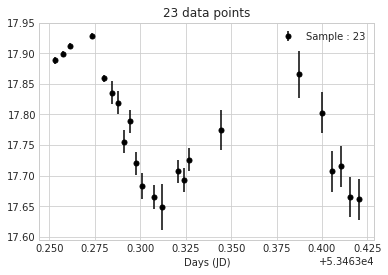

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title("%i data points"%(len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [43]:
(tsample.iloc[-1]-tsample[0])*24

4.019166666897945

In [22]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(17.75, 0.5).logpdf(params[0])
    #p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    ###print this line to get the prob value: p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    #p_period = scipy.stats.uniform(np.log(1./24.), -np.log(1./24.)).logpdf((params[3]))
    #p_period = scipy.stats.halfnorm(loc=np.log(0.5/24.), scale=np.exp(0.5/24.)).logpdf(params[3])
    #p_period = scipy.stats.halfcauchy(loc=np.log(0.5/24.), scale=np.exp(0.5/24.)).logpdf(params[3])
    p_period = scipy.stats.norm(np.log(4./24.), (12./24.)).logpdf(params[3])
    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior

def logl(params, gp, tsample, fsample, flux_err):
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)

    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25
    return lnlike

def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25

In [31]:
ndim, nwalkers = 4, 100

In [32]:
# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = np.log(0.5)

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(tsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
p0[:,3] = x


In [33]:
threads=4
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


In [34]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 20000)

CPU times: user 6min 48s, sys: 29.7 s, total: 7min 17s
Wall time: 1h 7min 51s


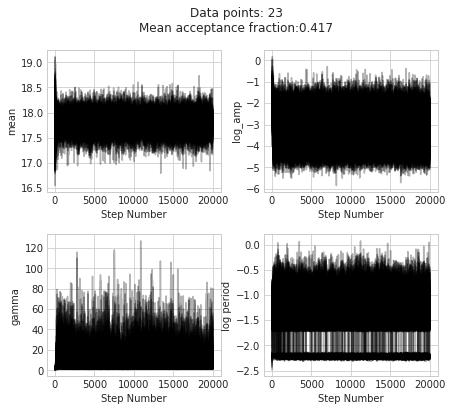

In [35]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'log period'], p0=[params], data_pts=len(fsample))

Text(0.5,0,'Period (hours)')

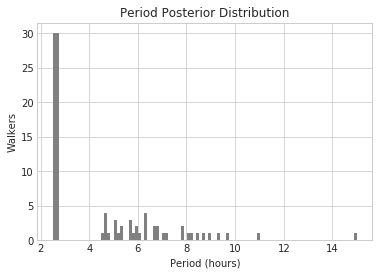

In [36]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(np.exp(end_period)*24., bins=100, color='grey')
fx.set_title('Period Posterior Distribution')
fx.set_ylabel('Walkers')
fx.set_xlabel('Period (hours)')

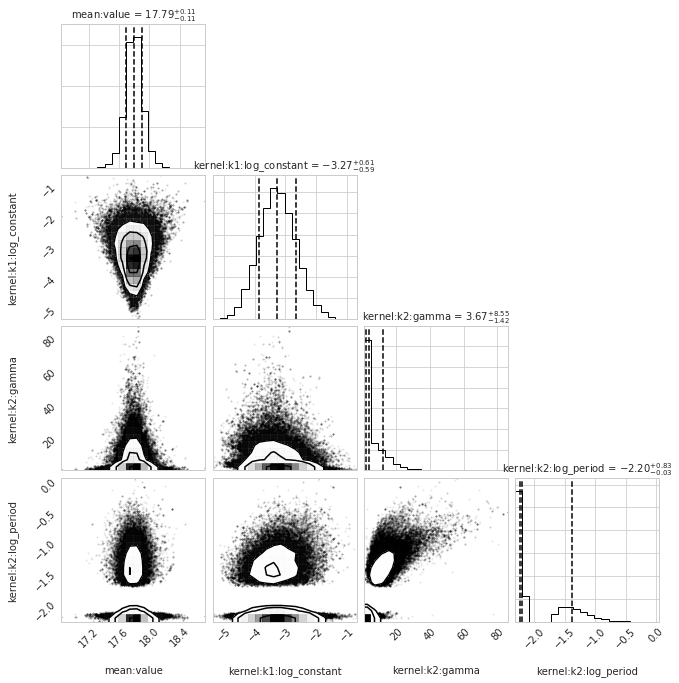

In [37]:
# make some labels
labels = list(gp.get_parameter_names())
#labels[3] = 'period'

# percentage of steps to plot
percent = 0.1

# generate list of last steps spanning backwards
x = list(range(-1,-int(sampler.iterations*percent)-1,-1))

# only plot x last steps
# reshape into 2d array instead of 3d
#sampler.chain[walker, step, param]
figure = corner.corner(sampler.chain[:,x,:].reshape(int(sampler.iterations*percent*sampler.k),4), 
                       labels=labels, quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 10})

The distribution of periods ended up looking like this.

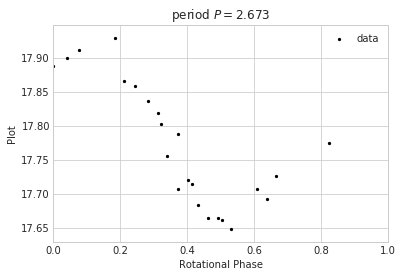

In [39]:
periods = np.exp(sampler.chain[:,-1,-1])
best_period = np.median(periods)
plot_folded_lightcurve(tsample, fsample, best_period)

We can now see how the different posterior distributions model the original sampled data. Feel free to give the file names **namestr** an appropriate title.

In [ ]:
def save_chain(file_name, sampler):
        header = str(sampler.chain.shape)
        np.savetxt(file_name, sampler.flatchain, header=header)
        return

filename = "5318_new_priors"

save_chain(filename + "_results.txt", sampler)

[17.86151256 -3.0680358  20.98741314 -1.38932734]
[17.61035547 -3.87540542  3.66513809 -2.21845091]
[17.79313122 -2.8303463   2.15250054 -2.19615956]
[17.830677   -3.64901517  9.99764931 -1.34453074]
[17.87652589 -2.20602659  3.50455406 -2.2100231 ]
[17.95954153 -2.71998303 16.4641807  -0.8779604 ]
[17.80650072 -3.51901353  3.50982743 -2.20059438]
[17.66986171 -2.37692017  2.73745211 -2.21676008]
[17.79451808 -3.66099103 15.34355044 -1.474319  ]
[17.78010686 -2.65812669  2.34240912 -2.23691011]


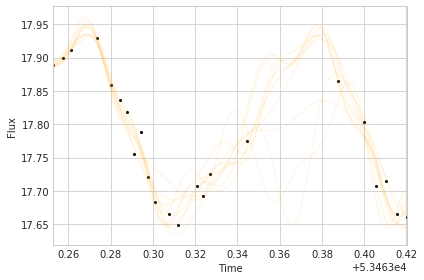

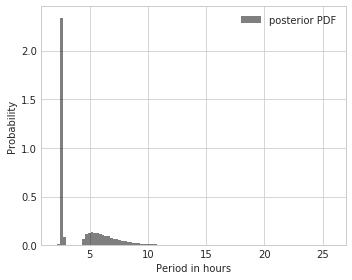

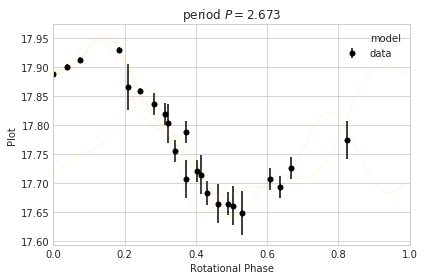

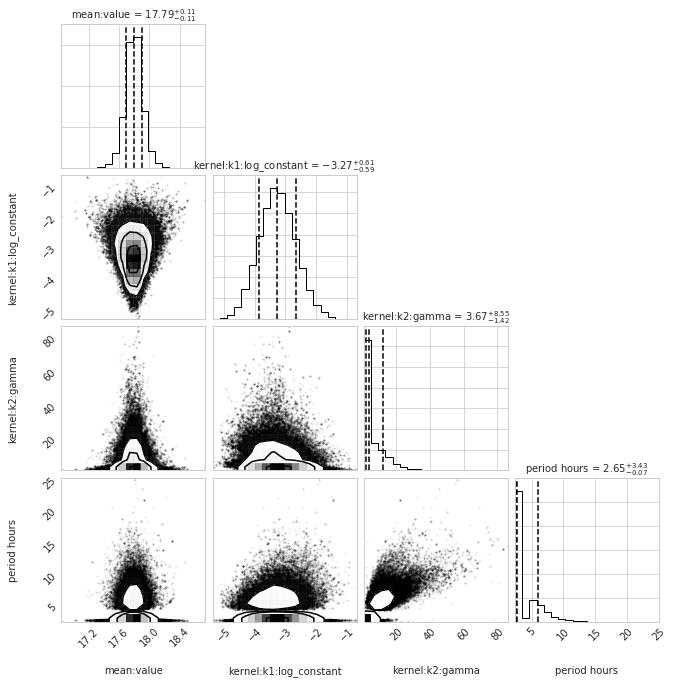

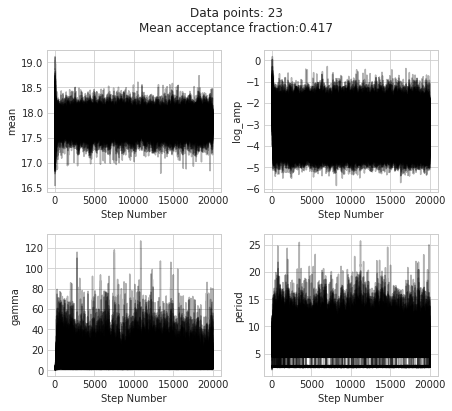

In [40]:
plot_mcmc_sampling_results(np.array(tsample), fsample, flux_err, gp, sampler, 
                           namestr="test" + "_plots", true_lightcurve=None, 
                           true_period=None)

###test failure with plotting if steps are too few